# Test forcasting with prophet

https://facebookincubator.github.io/prophet/

```Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.```

In [93]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

In [56]:
!which python

/home/wyoc/anaconda2/bin/python


In [57]:
client = Elasticsearch(hosts='172.16.0.11:9200')
body = """{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "site_id": {
              "value": 10
            }
          }
        },
        {
          "term": {
            "event_name": {
              "value": "page_visit"
            }
          }
        },
        {
          "range": {
            "created": {
              "gte": "now-500d/d",
              "lte": "now"
            }
          }
        }
      ]
    }
  },
  "aggs": {
    "date": {
      "date_histogram": {
        "field": "created",
        "interval": "day"
      },
      "aggs": {
        "unique": {
          "cardinality": {
            "field": "session_id"
          }
        }
      }
    }
  }
}"""
index = 'events'
response = client.search(index=index, 
                        body=body)

In [81]:
r = response['aggregations']['date']['buckets']
df_DS = pd.DataFrame([_r['key_as_string'] for _r in r])
df_y = pd.DataFrame([_r['unique']['value'] for _r in r])
df = pd.concat([df_DS, df_y], axis=1,)
df.columns = ['ds', 'y']
df.DS = df.ds.map(lambda x: x[:10])
df.head()

ds    y
0  2015-10-19T00:00:00.000Z   38
1  2015-10-20T00:00:00.000Z  233
2  2015-10-21T00:00:00.000Z  288
3  2015-10-22T00:00:00.000Z  230
4  2015-10-23T00:00:00.000Z  207

In [82]:
m = Prophet()
m.fit(df)

In [100]:
future = m.make_future_dataframe(periods=90)
future.tail()

ds
584 2017-05-25
585 2017-05-26
586 2017-05-27
587 2017-05-28
588 2017-05-29

In [104]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
584 2017-05-25   96.485402   15.377074  183.002086
585 2017-05-26   83.787781    2.324759  173.655035
586 2017-05-27   49.956919  -25.065475  133.043215
587 2017-05-28   86.770979    4.216755  172.251503
588 2017-05-29  113.950975   32.984563  197.008644

In [105]:
m.plot(forecast)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


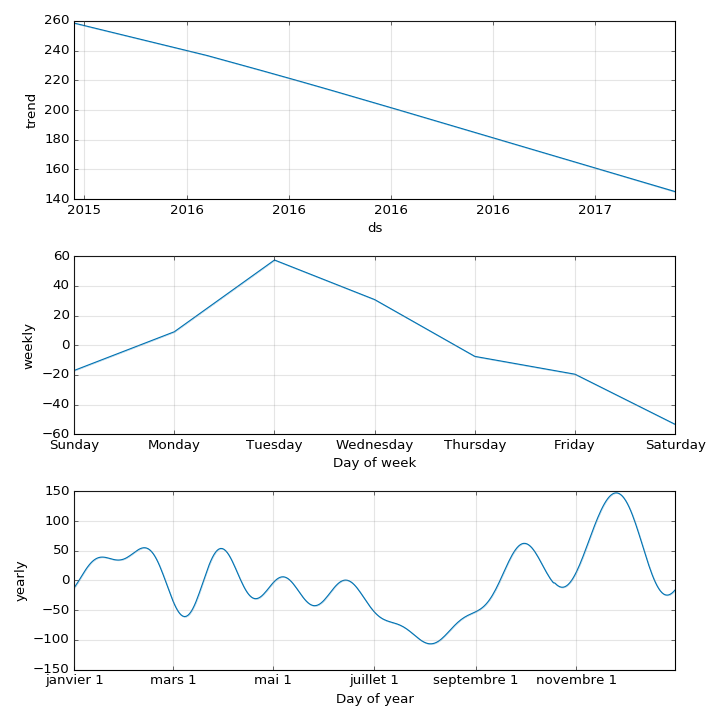

In [106]:
m.plot_components(forecast)
plt.show()